# Credmark Workshop for MetricsDAO

- 2023.6.20
- Join Credmark Discord: https://credmark.com/contact-us

1. Token (symbol, name, )
2. Contract (Uniswap V2)
3. Get the reserve, get the price
4. Get the reserve for the past
5. Get the reserve for a range of time.


## Initialize


In [1]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, BlockNumber

context, model_loader = create_cmf(show=True)

Credmark context created with 
- chain_id=1
- block_number=None
- chain_provider_url=https://no...om/1
- model_loader_path=['/home/vscode/.local/lib/python3.9/site-packages/models']
- api_url=https://gateway.credmark.com
- use_local_models=None



In [2]:
# print the chain ID, block number and block timestamp
print((context.chain_id,
       context.block_number,
       context.block_number.timestamp_datetime.isoformat()))

(1, 17490350, '2023-06-16T05:34:35+00:00')


## 1. Token


In [3]:
# WBTC token
wbtc = Token('0x2260fac5e5542a773aa44fbcfedf7c193bc2c599')
print((wbtc.symbol, wbtc.total_supply, wbtc.decimals))

# These values shall match closely with what's shown in
# https://etherscan.io/address/0x2260fac5e5542a773aa44fbcfedf7c193bc2c599#readContract
# We have shown as live, while EtherScan update some time ago.

('WBTC', 15662767544250, 8)


In [4]:
# Query the TokenTransfer table for WBTC

# We have these tables available
display(context.ledger.tables())

# columns in TokenTransfer table
display(context.ledger.TokenTransfer.columns)

['Block',
 'Contract',
 'Log',
 'Receipt',
 'Token',
 'TokenBalance',
 'TokenTransfer',
 'Trace',
 'Transaction']

['block_hash',
 'block_number',
 'block_timestamp',
 'from_address',
 'log_index',
 'token_address',
 'to_address',
 'transaction_hash',
 'value']

In [5]:
# Fetch the recent WBTC transfers

with context.ledger.TokenTransfer as q:
    df = q.select(columns=q.columns,
                  where=q.TOKEN_ADDRESS.eq(wbtc.address).and_(q.BLOCK_NUMBER.between_(context.block_number - 1000, context.block_number)),
                  order_by=q.BLOCK_NUMBER.desc(),
                  limit=1).to_dataframe()

display(df)

,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0xf9ad572982940870a630ac93a16280732033551ed682...,17490344,2023-06-16T05:33:23.000Z,0x9774a31b94f97963f776643b2f6690f9617de279,354,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,0x8d5dcb660a4701ded8a5981e6b97eff2437186b45800...,280512830


## 2. Contract

- We choose an exchange pool from Uniswap V2
- https://v2.info.uniswap.org/home
- V2 pool is simple because the ratio between two tokens' reserves is the price.

For example:

- The USDC-ETH pool is composed of two tokens: USDC and ETH.
- The pool's reserves are the total amount of USDC and ETH in the pool.
- ETH's price in USDC is USDC's reserve divided by ETH's reserve.


In [6]:
eth_usdc_pool = Contract('0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc')

# Explore the pool contract
display(dir(eth_usdc_pool.abi.functions))

['DOMAIN_SEPARATOR',
 'MINIMUM_LIQUIDITY',
 'PERMIT_TYPEHASH',
 'allowance',
 'approve',
 'balanceOf',
 'burn',
 'decimals',
 'factory',
 'getReserves',
 'initialize',
 'kLast',
 'mint',
 'name',
 'nonces',
 'permit',
 'price0CumulativeLast',
 'price1CumulativeLast',
 'skim',
 'swap',
 'symbol',
 'sync',
 'token0',
 'token1',
 'totalSupply',
 'transfer',
 'transferFrom']

In [7]:
# The detail of token0/token1/getReserves function
print(eth_usdc_pool.abi.functions.token0)
print('---')
print(eth_usdc_pool.abi.functions.token1)
print('---')
print(eth_usdc_pool.abi.functions.getReserves)

Function Name: token0
Args: []
Types: []
Output: ['address']
---
Function Name: token1
Args: []
Types: []
Output: ['address']
---
Function Name: getReserves
Args: []
Types: []
Output: ['uint112', 'uint112', 'uint32']


In [8]:
token0_addr = eth_usdc_pool.functions.token0().call()
token1_addr = eth_usdc_pool.functions.token1().call()

# The addresses of two tokens
print((token0_addr, token1_addr))

# Know what these tokens are actually are
token0 = Token(token0_addr)
token1 = Token(token1_addr)
print((token0.symbol, token1.symbol))

('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
('USDC', 'WETH')


In [9]:
# Get the reserve of two tokens in this pool
reserve = eth_usdc_pool.functions.getReserves().call()
print((reserve))

# split the return tuple to three values
_reserve0, _reserve1, _block_timestamp_last = reserve

# price of ETH (as token1) = reserve0 / reserve1, scaled by each token's decimals
price_eth = token0.scaled(_reserve0) / token1.scaled(_reserve1) # the ratio is USDC per WETH

print(price_eth)

[26019069339196, 15607984977437901596889, 1686893675]
1667.0357753936735


## 3. Write a model


In [10]:
from credmark.cmf.model import Model
from credmark.cmf.types import Contract, Token

@Model.describe(
    slug='jit.uniswap-v2-reserve',
    version='1.1',
    input=Contract,
    output=dict)
class UniswapV2Reserve(Model):
    def run(self, input: Contract):
        # get the tokens in this pool
        token0_addr = input.functions.token0().call()
        token1_addr = input.functions.token1().call()
        # create the Token objects
        token0 = Token(token0_addr)
        token1 = Token(token1_addr)
        # get the reserve
        _reserve0, _reserve1, _block_timestamp_last = input.functions.getReserves().call()
        # calculate the price
        price_token1 = token0.scaled(_reserve0) / token1.scaled(_reserve1)
        # return the result
        return {'price_token1': price_token1,
                'price_token0': 1 / price_token1,
                'reserve0': _reserve0,
                'reserve1': _reserve1}


# We can save this as a file in the models/ directory of credmark-models-py, or model_loader_path shown above for create_cmf().
# Here we directly load it from the definition, with this way, it can only be used in this notebook.
context.add_model(UniswapV2Reserve)

In [11]:
context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

# model checks for validity of the input
# try run above with a shorter address, i.e. 0xB4e16d0168e52d35CaCD2c6185b44
# You will get a ModelInputError

{'price_token1': 1667.0357753936735,
 'price_token0': 0.0005998671502798722,
 'reserve0': 26019069339196,
 'reserve1': 15607984977437901596889}

In [12]:
# We can run model on earlier block
# Model is a re-usable piece of algorithm to run for a chain_id, a block_number

earlier_block = context.block_number - 1_000

display(earlier_block.timestamp_datetime)

context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                  block_number=earlier_block)

datetime.datetime(2023, 6, 16, 2, 11, 23, tzinfo=datetime.timezone.utc)

{'price_token1': 1662.289617698822,
 'price_token0': 0.0006015798867734868,
 'reserve0': 25981788957921,
 'reserve1': 15630121659478743059873}

## 4. Scale up the model for more blocks


In [13]:
# Run the model for 1000 blocks will take a while, how could we speed up?

for offset in range(10):
    context.run_model('jit.uniswap-v2-reserve',
                      {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                      block_number=context.block_number - offset)

In [14]:
# Uniswap V2 pool's reserve changes with Mint/Burn/Swap, it kept a record of these events.
# Event Sync occurs together with Mint/Burn to record the reserve, that's we need.

eth_usdc_pool.abi.events.Sync

Event Name: Sync
Args: ['reserve0', 'reserve1']
Types: ['uint112', 'uint112']

In [15]:
# Let's query the ledger database for the event log for Sync.
# Querying this data only takes less than a second.

with eth_usdc_pool.ledger.events.Sync as q:
    df = q.select(columns=q.columns,
                  where=q.BLOCK_NUMBER.ge(context.block_number-1000),
                  order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

# Note: Because we limit each query to return 5000 results
# We may query multiple times to get all the results till we have exhausted all the results.

display(df)

,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_reserve0,evt_reserve1
0,17489357,2023-06-16T02:12:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,29,"Sync(uint112,uint112)",0xc6bd76ab52539964c321a4fb7ddba9a2280050c3b926...,25980814539558,15630709635881702118941
1,17489357,2023-06-16T02:12:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,109,"Sync(uint112,uint112)",0x657e08a9de38f229e494b3045d85b053f82ab1ade66a...,25980635035136,15630817955950854927284
2,17489361,2023-06-16T02:13:35.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,294,"Sync(uint112,uint112)",0x8d70fea2a4783f4abc28ea1a33c0aebc4f22c0da974c...,25980618608595,15630827868450854927284
3,17489362,2023-06-16T02:13:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,96,"Sync(uint112,uint112)",0x8b6868bd5d09254e58febbdb7b1d1d5e427432a31c68...,25983509005880,15629094315852252992723
4,17489364,2023-06-16T02:14:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,135,"Sync(uint112,uint112)",0x0b0f8f04003d245abb5b9c0ad578369a3ca12cdda933...,25983562191165,15629062420913407969516
...,...,...,...,...,...,...,...,...
106,17490205,2023-06-16T05:04:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,366,"Sync(uint112,uint112)",0xc0601d763ba3d8965e250d4fa03dbaf93f29f92449fc...,26013513739499,15611302177491916769705
107,17490214,2023-06-16T05:06:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,57,"Sync(uint112,uint112)",0x7f3b2f92117a28c86da161a4f2d522c56bfa37483f60...,26013534739499,15611289612731389034399
108,17490216,2023-06-16T05:07:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,52,"Sync(uint112,uint112)",0xb56e0ea055e4e9b9e69bf38cbf0c3fe15c08b0849d1d...,26014941687338,15610447851054956587536
109,17490233,2023-06-16T05:10:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,87,"Sync(uint112,uint112)",0x9b6b96b4a418bb9af2425c070e80937b52c9b3208983...,26014276537202,15610848190273198373147


,block_number,reserve0,reserve1,price_token1,price_token0
0,17489350,2.598064e+13,15630817955950854927284,1662.141745,0.000602
1,17489351,2.598064e+13,15630817955950854927284,1662.141745,0.000602
2,17489352,2.598064e+13,15630817955950854927284,1662.141745,0.000602
3,17489353,2.598064e+13,15630817955950854927284,1662.141745,0.000602
4,17489354,2.598064e+13,15630817955950854927284,1662.141745,0.000602
...,...,...,...,...,...
996,17490346,2.601560e+13,15610058490765437373332,1666.591868,0.000600
997,17490347,2.601560e+13,15610058490765437373332,1666.591868,0.000600
998,17490348,2.601560e+13,15610058490765437373332,1666.591868,0.000600
999,17490349,2.601560e+13,15610058490765437373332,1666.591868,0.000600


<Axes: xlabel='block_number'>

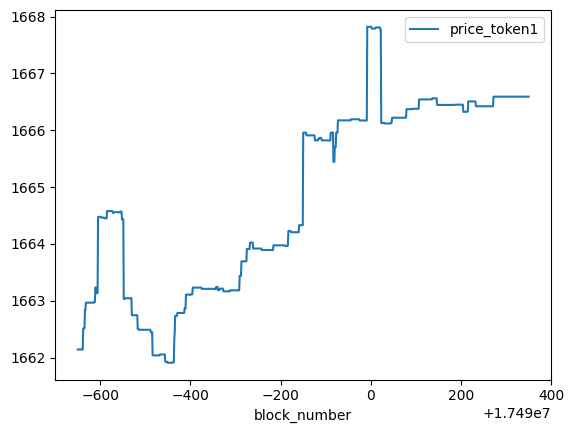

In [16]:
import pandas as pd

df_clean = (df
            .drop_duplicates(subset=['block_number'], keep='last')
            .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
            .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
            .assign(block_number=lambda x: x.block_number.astype(int),
                    reserve0=lambda x: x.reserve0.apply(int),
                    reserve1=lambda x: x.reserve1.apply(int),))

df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
df_clean['price_token0'] = 1 / df_clean['price_token1']

df_clean = (df_clean
            .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
            .sort_values('block_number')
            .fillna(method='ffill')
            .fillna(method='bfill'))

display(df_clean)

df_clean.plot('block_number', 'price_token1')

## Summary

What we have go through in CMF

- Initialize context in cmf
- Token: create it from address: query attributes, name, symbol, decimals, etc.
- Contract: create it from address, make web3 call.
- Write a model with web3 call
- Query ledger DB to get decoded event log
- Post-process the data in DataFrame
